In [1]:
import numpy as np
from numpy import mean, absolute
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from scipy.linalg import pinv

from sklearn.metrics import roc_curve

import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
###########################################################################
# 1. Anomaly detectors
###########################################################################

# The euclideanTrain and euclideanScore functions comprise the
# Euclidean anomaly detector.  During training, the detector takes a
# set of password-timing vectors (encoded as rows in a matrix) and
# calculates the mean vector.  This mean vector is returned as the
# detection model.  During scoring, the detector takes the detection
# model and a new set of password-timing vectors (also encoded as rows
# in a matrix) and calculates the squared Euclidean distance between
# the mean vector and each of the new password-timing vectors.  These
# scores are returned in a vector whose length is equal to the number
# of password-timing vectors in the scoring matrix.

def euclideanTrain(YTrain):
    dmod = {'mean': np.mean(YTrain, axis=0)}
    return dmod


def euclideanScore(dmod, YScore):
    p = len(dmod['mean'])
    n = YScore.shape[0]

    if YScore.shape[1] != p:
        raise ValueError("Training/test feature length mismatch")

    meanMatrix = np.tile(dmod['mean'], (n, 1))

    scores = np.sum(np.square(YScore - meanMatrix), axis=1)

    return scores


# The manhattanTrain and manhattanScore functions comprise the
# Manhattan anomaly detector.  During training, the detector takes a
# set of password-timing vectors (encoded as rows in a matrix) and
# calculates the mean vector.  This mean vector is returned as the
# detection model.  During scoring, the detector takes the detection
# model and a new set of password-timing vectors (also encoded as rows
# in a matrix) and calculates the Manhattan distance between the mean
# vector and each of the new password-timing vectors.  These scores
# are returned in a vector whose length is equal to the number of
# password-timing vectors in the scoring matrix.

def manhattanTrain(YTrain):
    dmod = {'mean': np.mean(YTrain, axis=0)}
    return dmod


def manhattanScore(dmod, YScore):
    p = len(dmod['mean'])
    n = YScore.shape[0]

    if YScore.shape[1] != p:
        raise ValueError("Training/test feature length mismatch")

    meanMatrix = np.tile(dmod['mean'], (n, 1))

    scores = np.sum(np.abs(YScore - meanMatrix), axis=1)

    return scores


# Scaled Manhattan distance
def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)

def manhattanScaledTrain(YTrain):
    dmod = {'mean': np.mean(YTrain, axis=0), 'mad': mad(YTrain,0)}
    return dmod


def manhattanScaledScore(dmod, YScore):
    p = len(dmod['mean'])
    n = YScore.shape[0]
    
    if YScore.shape[1] != p:
        raise ValueError("Training/test feature length mismatch")

    meanMatrix = np.tile(dmod['mean'], (n, 1))
    scores = np.sum(np.abs(YScore - meanMatrix)/dmod["mad"].T, axis=1)
    return scores


# The mahalanobisTrain and mahalanobisScore functions comprise the
# Mahalanobis anomaly detector.  During training, the detector takes a
# set of password-timing vectors (encoded as rows in a matrix) and
# calculates the mean vector and also the inverse of the covariance
# matrix.  This vector and matrix are returned as the detection model.
# During scoring, the detector takes the detection model and a new set
# of password-timing vectors (also encoded as rows in a matrix) and
# calculates the squared Mahalanobis distance between the mean vector
# and each of the new password-timing vectors.  These scores are
# returned in a vector whose length is equal to the number of
# password-timing vectors in the scoring matrix.

def mahalanobisTrain(YTrain):
    dmod = {'mean': np.mean(YTrain, axis=0), 'covInv': pinv(
        np.cov(YTrain, rowvar=False))}
    return dmod


def mahalanobisR(X, meanCol, IC):
    m = []
    for i in range(X.shape[0]):
        m.append(distance.mahalanobis(X[i], meanCol, IC) ** 2)
    return(m)


def mahalanobisScore(dmod, YScore):
    p = len(dmod['mean'])
    n = YScore.shape[0]

    if YScore.shape[1] != p:
        raise ValueError("Training/test feature length mismatch")

    scores = mahalanobisR(YScore, dmod['mean'], dmod['covInv'])

    return scores


detectorSet = {
    'Euclidean': {
        'train': euclideanTrain,
        'score': euclideanScore
    },
    'Manhattan': {
        'train': manhattanTrain,
        'score': manhattanScore
    },
    'ManhattanScaled':{
        'train': manhattanScaledTrain,
        'score': manhattanScaledScore
    },
    'Mahalanobis': {
        'train': mahalanobisTrain,
        'score': mahalanobisScore
    }
}

In [3]:
###########################################################################
# 2. Evaluation procedures
###########################################################################

# The calculateEqualError function takes a set of user scores and
# impostor scores, makes an ROC curve using the ROCR functionality,
# and then geometrically calculates the point at which the miss and
# false-alarm (i.e., false-negative and false-positive) rates are
# equal.


def calculateEqualError(userScores, impostorScores):

    predictions = np.concatenate((userScores, impostorScores), axis=None)
    labels = [0] * len(userScores) + [1] * len(impostorScores)

    fpr, tpr, thresholds = roc_curve(labels, predictions)
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]

    # print(eer)
    # print(thresholds)
    #dists = tpr - fpr
    # print(dists)
    #idx1 = next(i for i, dist in enumerate(dists) if dist == min(dists[dists >= 0]))
    #idx2 = next(i for i, dist in enumerate(dists) if dist == max(dists[dists < 0]))
    # print(idx1)
    #assert len([idx1]) == 1
    #assert len([idx2]) == 1
    #assert abs(idx1 - idx2) == 1

    #x = [tpr[idx1], fpr[idx1]]
    #y = [tpr[idx2], fpr[idx2]]
    #a = (x[0] - x[1]) / (y[1] - x[1] - y[0] + x[0])
    #eer = x[0] + a * (y[0] - x[0])

    return eer


def evaluateSubject(train, eval, evalSubject, detectorTrain, detectorScore):
    # Extract the training, user scoring, and impostor scoring matrices
    # for the subject. The training matrix is the first 200 password
    # repetitions for the subject, corresponding to the first 4 sessions
    # of passwords. The user scoring matrix is the last 200 password
    # repetitions, and the impostor scoring matrix is the first 5
    # repetitions from all the other subjects.

    YTrain = train.loc[(train['subject'] == evalSubject) & (
        train['sessionIndex'] <= 4), ~train.columns.isin(['subject', 'sessionIndex', 'rep'])].values

    YScore0 = eval.loc[(eval['subject'] == evalSubject) & (
        eval['sessionIndex'] > 4), ~eval.columns.isin(['subject', 'sessionIndex', 'rep'])].values

    YScore1 = train.loc[(train['subject'] != evalSubject) & (train['sessionIndex'] == 1) & (
        train['rep'] <= 5), ~train.columns.isin(['subject', 'sessionIndex', 'rep'])].values

    # Run the training and scoring
    dmod = detectorTrain(YTrain)
    userScores = detectorScore(dmod, YScore0)
    impostorScores = detectorScore(dmod, YScore1)

    eer = calculateEqualError(userScores, impostorScores)

    return eer

In [4]:
###########################################################################
# 3. Main procedure
###########################################################################
def eval(train, eval) -> pd.DataFrame:
    # Retrieve the list of subjects
    subjects = sorted(train["subject"].unique())

    training_set = train
    eval_set = eval


    # For each of the detectors, evaluate the detector on each subject,
    # and record the equal-error rates in a dictionary.

    eers = {}

    for detectorName, detector in detectorSet.items():

        #print(f"Evaluating the {detectorName} detector")
        detectorTrain = detector['train']
        detectorScore = detector['score']

        eers[detectorName] = np.full(len(subjects), np.nan)

        for i, subject in enumerate(subjects):
            eer = evaluateSubject(training_set, eval_set, subject,
                                detectorTrain=detectorTrain,
                                detectorScore=detectorScore)

            eers[detectorName][i] = eer
            #print(f"  {i+1}/{len(subjects)}: {eer}", end='\r')

        #print(f"  average equal-error: {np.mean(eers[detectorName])}")

    #print("Tabulating results:")

    eers = pd.DataFrame(eers, index=subjects)

    res = pd.DataFrame({'eer.mean': eers.mean(), 'eer.sd': eers.std()})
    res = res.round(decimals=3)

    return res

In [5]:
original = pd.read_csv('./DSL-StrongPasswordData.csv')

In [6]:
# Original
original_out = eval(original, original)

In [7]:
# Firefox unisolated warm up | resistFingerprinting
firefox_unisolated_resist = pd.read_csv('./firefox_resistFP/firefox_unisolated_resistFP/full_data_set.csv')
firefox_unisolated_resist_out = eval(original, firefox_unisolated_resist)

In [8]:
# Firefox unisolated warm up | resistFingerprinting 20ms
firefox_unisolated_resist_20ms = pd.read_csv('./firefox_resistFP_20/firefox_unisolated_resistFP_20ms/full_data_set.csv')
firefox_unisolated_resist_20ms_out = eval(original,firefox_unisolated_resist_20ms)

In [9]:
# Firefox unisolated warm up | resistFingerprinting 33ms
firefox_unisolated_resist_33ms = pd.read_csv('./firefox_resistFP_33/firefox_unisolated_resistFP_33ms/full_data_set.csv')
firefox_unisolated_resist_33ms_out = eval(original,firefox_unisolated_resist_33ms)

In [10]:
# Firefox unisolated warm up | resistFingerprinting 40ms
firefox_unisolated_resist_40ms = pd.read_csv('./firefox_resistFP_40/firefox_unisolated_resistFP_40ms/full_data_set.csv')
firefox_unisolated_resist_40ms_out = eval(original,firefox_unisolated_resist_40ms)

In [11]:
# Firefox unisolated warm up | resistFingerprinting 60ms
firefox_unisolated_resist_60ms = pd.read_csv('./firefox_resistFP_60/firefox_unisolated_resistFP_60ms/full_data_set.csv')
firefox_unisolated_resist_60ms_out = eval(original,firefox_unisolated_resist_60ms)

In [12]:
# Firefox unisolated warm up | resistFingerprinting 80ms
firefox_unisolated_resist_80ms = pd.read_csv('./firefox_resistFP_80/firefox_unisolated_resistFP_80ms/full_data_set.csv')
firefox_unisolated_resist_80ms_out = eval(original,firefox_unisolated_resist_80ms)

In [13]:
# Firefox unisolated warm up | resistFingerprinting 100ms
firefox_unisolated_resist_100ms = pd.read_csv('./firefox_resistFP_100/firefox_unisolated_resistFP_100ms/full_data_set.csv')
firefox_unisolated_resist_100ms_out = eval(original,firefox_unisolated_resist_100ms)

In [14]:
# Firefox unisolated warm up | resistFingerprinting 120ms
firefox_unisolated_resist_120ms = pd.read_csv('./firefox_resistFP_120/firefox_unisolated_resistFP_120ms/full_data_set.csv')
firefox_unisolated_resist_120ms_out = eval(original,firefox_unisolated_resist_120ms)

In [15]:
# Firefox unisolated warm up | resistFingerprinting 140ms
firefox_unisolated_resist_140ms = pd.read_csv('./firefox_resistFP_140/firefox_unisolated_resistFP_140ms/full_data_set.csv')
firefox_unisolated_resist_140ms_out = eval(original,firefox_unisolated_resist_140ms)

In [16]:
# Firefox unisolated warm up | resistFingerprinting 160ms
firefox_unisolated_resist_160ms = pd.read_csv('./firefox_resistFP_160/firefox_unisolated_resistFP_160ms/full_data_set.csv')
firefox_unisolated_resist_160ms_out = eval(original,firefox_unisolated_resist_160ms)

In [17]:
# Firefox unisolated warm up | resistFingerprinting 180ms
firefox_unisolated_resist_180ms = pd.read_csv('./firefox_resistFP_180/firefox_unisolated_resistFP_180ms/full_data_set.csv')
firefox_unisolated_resist_180ms_out = eval(original,firefox_unisolated_resist_180ms)

In [ ]:
# Firefox unisolated warm up | resistFingerprinting 200ms
firefox_unisolated_resist_200ms = pd.read_csv('./firefox_resistFP_200/firefox_unisolated_resistFP_200ms/full_data_set.csv')
firefox_unisolated_resist_200ms_out = eval(original,firefox_unisolated_resist_200ms)

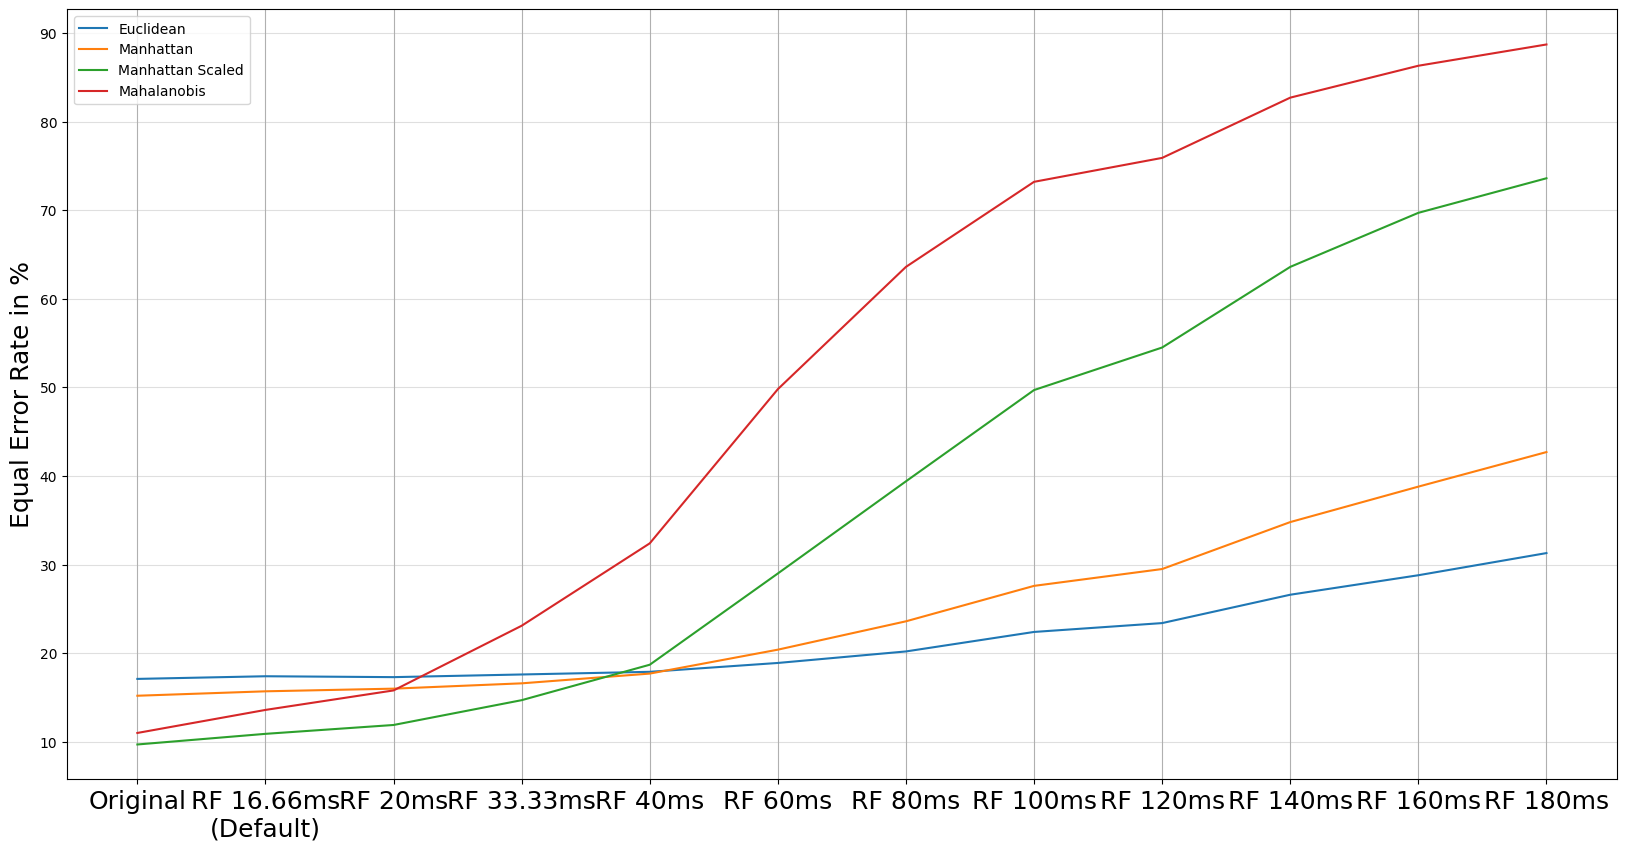

In [19]:
# plot authentification
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ]#13 ]
labels = ['Original', 'RF 16.66ms\n(Default)', 'RF 20ms', 'RF 33.33ms', 'RF 40ms', 'RF 60ms', 'RF 80ms', 
          'RF 100ms', 'RF 120ms',  'RF 140ms', 'RF 160ms', 'RF 180ms', ]#'RF 200ms']

y_ticks = np.arange(5,100,5)

y_euclidean = [
    original_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_20ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_33ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_40ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_60ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_80ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_100ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_120ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_140ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_160ms_out.iloc[0]['eer.mean'] * 100,
    firefox_unisolated_resist_180ms_out.iloc[0]['eer.mean'] * 100,
    #firefox_unisolated_resist_200ms_out.iloc[0]['eer.mean'] * 100,
]

y_manhattan = [
    original_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_20ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_33ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_40ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_60ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_80ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_100ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_120ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_140ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_160ms_out.iloc[1]['eer.mean'] * 100,
    firefox_unisolated_resist_180ms_out.iloc[1]['eer.mean'] * 100,
    #firefox_unisolated_resist_200ms_out.iloc[1]['eer.mean'] * 100,
]

y_manhattan_scaled = [
    original_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_20ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_33ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_40ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_60ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_80ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_100ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_120ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_140ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_160ms_out.iloc[2]['eer.mean'] * 100,
    firefox_unisolated_resist_180ms_out.iloc[2]['eer.mean'] * 100,
    #firefox_unisolated_resist_200ms_out.iloc[2]['eer.mean'] * 100,
]

y_mahalanobis = [
    original_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_20ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_33ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_40ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_60ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_80ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_100ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_120ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_140ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_160ms_out.iloc[3]['eer.mean'] * 100,
    firefox_unisolated_resist_180ms_out.iloc[3]['eer.mean'] * 100,
    #firefox_unisolated_resist_200ms_out.iloc[3]['eer.mean'] * 100,
]


plt.plot(x, y_euclidean,  label="Euclidean")
plt.plot(x, y_manhattan,  label="Manhattan")
plt.plot(x, y_manhattan_scaled,  label="Manhattan Scaled")
plt.plot(x, y_mahalanobis,  label="Mahalanobis")


plt.title("", fontsize=18)
plt.ylabel("Equal Error Rate in %", fontsize=18)
plt.xticks(x, labels, rotation=0, fontsize=18)
#plt.yticks(y_ticks,fontsize=18)
plt.legend()
plt.grid(axis='y', alpha= 0.4)
plt.grid(axis='x', alpha=1.)
plt.show()